# 5. Boosting algortihms (Theory)

This notebook will resume theorical concepts about boosting algorithms and it will show some useful plots and graphs for an easily understanding.

### Index:
1. [Introduction](#1.-Introduction)
2. [AdaBoost](#2.-AdaBoost)
3. [Gradient Boosting](#3.-Gradient-Boosting)
4. [XGBoost](#4.-XGBoost)
5. [LightGBM](#5.-LightGBM)
6. [CatBoost](#6.-CatBoost)

# 1. Introduction

Boosting algorithms were created in 1997 with the emergence of AdaBoost (by Freund & Schapire). They work building some weak learners (simple models) and ensembling them, creating a complex model. Also, these weak learners, in our case decision trees, are built sequentially; so, every decision tree (except the first) is allowed to correct the errors made by the last one. It's possible taking into account the weight of each sample and modifying it in each step.

There are some boosting algorithms and some versions of each one. We will study: AdaBoost, Gradient Boosting, XGBoost, LightGBM and CatBoost.

We also show some examples. That's the reason why we will need these python packages:

In [1]:
#We load packages required:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint, random
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 2. AdaBoost

#### 2.1 Theory

AdaBoost was the first boosting algorithm created. It uses stumps as a weak learners, i.e., decision trees with only two leaf nodes. These weak learners are very imprecise, but the combination of them and the way of building them results in a very attractive method.

The AdaBoot algorithm we will analyze is:

<img src=https://i.stack.imgur.com/ljZmk.jpg>

Firstly, we assign the same weight for all samples, because we haven't done any prediction yet. So:

\begin{equation}
w_i = 1/N \, \, \, \forall i \in \{ 1, 2, \dots, N \}
\end{equation}

Then, we fit our stump ($G_m(x)$) using the weighted training data (if m = 1, we fit it like always), and we calculate the error made by the stump with:

\begin{equation}
err_m = \frac{\sum_{i=1}^{N} w_i I(y_i \neq G_m(x_i))}{\sum_{i=1}^{N} w_i}
\end{equation}

In this expression we have the sum of weights from incorrect classified values divided by the sum of total weights. The denominator is necessary in the expression because we can find a case where $\sum_{i=1}^{N} w_i \neq 1$ due to posterior modifications. So, if we define $err_m$ as we say, we can be sure of: $err_m \in [0, 1]$.

Note that in first step ( m = 1 ):

\begin{equation}
err_1 = \frac{\sum_{i=1}^{N} w_i I(y_i \neq G_1(x_i))}{\sum_{i=1}^{N} w_i} = \frac{\frac{1}{N} \sum_{i=1}^{N}I(y_i \neq G_1(x_i))}{1} = \frac{num\_of\_errors}{N}
\end{equation}

Now, in 3c, we can observe that we have to define:

\begin{equation}
\alpha_m = \log \left( \frac{1 - err_m}{err_m} \right)
\end{equation}

This value is also called: 'Amount of Say' for the stump. Let's plot this function to get conclusions:

<ipython-input-2-239794c50a78>:2: RuntimeWarning: divide by zero encountered in true_divide
  alpha = lambda x: np.log((1- x)/x)
<ipython-input-2-239794c50a78>:2: RuntimeWarning: divide by zero encountered in log
  alpha = lambda x: np.log((1- x)/x)


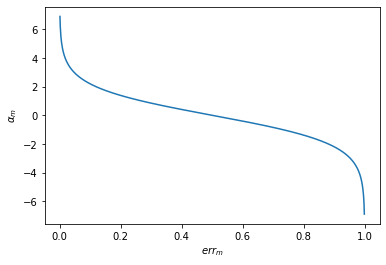

In [2]:
#We define our function:
alpha = lambda x: np.log((1- x)/x)

#We plot it:
x = np.linspace(0, 1, 1000)

plt.plot(x, alpha(x))
plt.xlabel(r'$err_m$')
plt.ylabel(r'$\alpha_m$')
plt.show()



As we can see, a good classification job ($err_m \simeq 0$) implies high $\alpha_m$ values. On the other hand, a poor classification job implies high negative values of $\alpha_m$.

Ending with the loop, we only have to reassign weights to training observations. The process to do it is defining:
\begin{equation*}
w_i^{m+1} =
\left\{
\begin{array}{crl}
w_i^m & if & y_i = G_m(x_i) \\
w_i^m e^{\alpha_m} & if & y_i \neq G_m(x_i) \\
\end{array}
\right.
\end{equation*}
where $w_i^m$ is the weight of the observation i in the iteration m.

With this reassignment we obtain an increasement of weights of misclassified observations.

Before starting with the last step, we have to emphasize the way of building stumps. Where m = 1, we use the Gini index as a impurity function:
\begin{equation*}
G_{region} = \sum_{k=1}^K p_{rk}(1 - p_{rk}) = 1 - \sum_{k=1}^K p_{rk}^2
\end{equation*}
where $p_{rk}$ is the proportion of training observations from class k that are in region r; and K is the total number of classes. In the same way, each node determines two regions; so we can define:
\begin{equation*}
G_{node} = \frac{n_1}{n_1 + n_2}G_1 + \frac{n_2}{n_1 + n_2}G_2
\end{equation*}
where $n_1$ and $n_2$ are the number of observations in each region, respectively. That allows us to determinate which is the region that minimizes Gini index and to choose the correct variable and the value that make this regions.

Nevertheless, this Gini index is only correct where all observations have the same weight. So, where m > 1, we need to find a way to solve the weights problem. The solution proposed in this notebook, and which is implemented in Python, is considering standardized weights as relative frequencies and calculating the cumulative frequency. Then, we only have tu generate n random numbers between 0 and 1 and identify with which row is associated in terms of its cumulative frequency to create a new dataset with same length where the misclassified rows have more presence. We can see it clearly at next example.

#### 2.2 Example step by step

To end with AdaBoost algorithm, we will show, step by step, which is the process with an example. We will use the dataset 'Rain in Australia' like in the other notebooks but choosing only 10 random observations and the variables: 'Humidity3pm' and 'Cloud3pm'.

In [5]:
#We load data:
weather = pd.read_parquet('../data/04_model_input/master.parquet')

#We choose the variables and observations we are interested in:
observations = [randint(0, len(weather)) for n in range(0, 10)]
model_columns = ['Humidity3pm', 'Cloud3pm']

#We put it in train variable and solve Nan problems
train = weather.loc[observations, model_columns + ['RainTomorrow']].fillna(-1).reset_index(drop = True)

#We show it:
train

,Humidity3pm,Cloud3pm,RainTomorrow,Weight
0,88.0,-1.0,1.0,0.1
1,27.0,-1.0,0.0,0.1
2,69.0,-1.0,0.0,0.1
3,82.0,8.0,1.0,0.1
4,54.0,-1.0,0.0,0.1
5,36.0,7.0,0.0,0.1
6,36.0,7.0,0.0,0.1
7,92.0,8.0,1.0,0.1
8,66.0,6.0,0.0,0.1
9,52.0,4.0,1.0,0.9


At first step, we put $w_i = \frac{1}{N} = \frac{1}{10}$:

In [6]:
#We add the weights to our dataframe:
weights = [1/10 for n in range(0, 10)]
train['Weight'] = weights
train

,Humidity3pm,Cloud3pm,RainTomorrow,Weight
0,88.0,-1.0,1.0,0.1
1,27.0,-1.0,0.0,0.1
2,69.0,-1.0,0.0,0.1
3,82.0,8.0,1.0,0.1
4,54.0,-1.0,0.0,0.1
5,36.0,7.0,0.0,0.1
6,36.0,7.0,0.0,0.1
7,92.0,8.0,1.0,0.1
8,66.0,6.0,0.0,0.1
9,52.0,4.0,1.0,0.1


Now, we have to create a stump with our two variables:

In [7]:
#We create a decision tree with max_depth = 1:
model_tree = DecisionTreeClassifier(max_depth = 1)

model_tree.fit(train[model_columns], train.RainTomorrow)

DecisionTreeClassifier(max_depth=1)

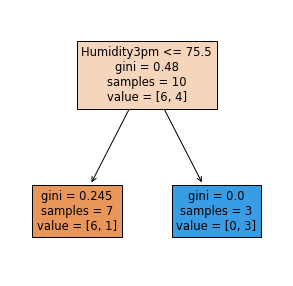

In [8]:
plt.figure(figsize = (5, 5))
plot_tree(model_tree, feature_names = model_columns, filled = True);

As we can see, one leaf node has a Gini index equal to 0 but the other leaf node has some errors. Let's see the space partition:

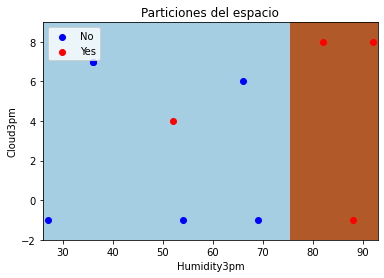

In [9]:
x_ex1 = train[model_columns].fillna(-1)
y_ex1 = train.RainTomorrow

n_classes = 2
plot_colors = 'bry'
plot_step = 0.02

x_min, x_max = x_ex1['Humidity3pm'].min() - 1, x_ex1['Humidity3pm'].max() + 1
y_min, y_max = x_ex1['Cloud3pm'].min() - 1, x_ex1['Cloud3pm'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

z = model_tree.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)
cs = plt.contourf(xx, yy, z, cmap = plt.cm.Paired)

plt.xlabel('Humidity3pm')
plt.ylabel('Cloud3pm')
plt.axis('tight')

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_ex1 == i)[0]
    x_graph = []
    y_graph = []
    for j in idx:
        x_graph += [x_ex1.Humidity3pm.iloc[j]]
        y_graph += [x_ex1.Cloud3pm.iloc[j]]
        
    plt.scatter(x_graph, y_graph, c = color, label = ['No', 'Yes'][i] , cmap = plt.cm.Paired)
    
plt.axis('tight')
    
plt.title('Particiones del espacio')
plt.legend(loc = 'best')
plt.show()

Now, we have to calculate $err_m$. As we say before:
\begin{equation*}
err_m = err_1 = \frac{num\_of\_errors}{n} = \frac{1}{10} = 0.1
\end{equation*}

We continue computing $\alpha_m$:
\begin{equation*}
\alpha_m = \alpha_1 = \log{\frac{1 - err_1}{err_1}} = \log{\frac{1- 0.1}{0.1}} = \log{\frac{0.9}{0.1}} = \log{9} \simeq 2.1972
\end{equation*}

And we can calculate the new weights:
\begin{equation*}
w_i^{m+1} =
\left\{
\begin{array}{crl}
w_i^m & if & y_i = G_m(x_i) \\
w_i^m e^{\alpha_m} & if & y_i \neq G_m(x_i) \\
\end{array}
\right.
\Rightarrow
w_i^{2} =
\left\{
\begin{array}{crl}
w_i^1 & if & i \neq 9 \\
w_i^1 e^{\alpha_1} & if & i = 9 \\
\end{array}
\right.
\Rightarrow
w_i^{2} =
\left\{
\begin{array}{crl}
w_i^1 & if & i \neq 9 \\
9 w_i^1  & if & i = 9 \\
\end{array}
\right.
\end{equation*}

So, adding the updated weights:

In [85]:
weights[9] = 9 * weights[9]
train['Weight'] = weights
train

,Humidity3pm,Cloud3pm,RainTomorrow,Weight
0,88.0,-1.0,1.0,0.1
1,27.0,-1.0,0.0,0.1
2,69.0,-1.0,0.0,0.1
3,82.0,8.0,1.0,0.1
4,54.0,-1.0,0.0,0.1
5,36.0,7.0,0.0,0.1
6,36.0,7.0,0.0,0.1
7,92.0,8.0,1.0,0.1
8,66.0,6.0,0.0,0.1
9,52.0,4.0,1.0,0.9


So, next stump will be build creating a new weighted sample, and the contribution of this stump in final response will be $\alpha_1 \simeq 2.1972$

To create the new weighted sample, we have to standardize the weights and write the cumulative frequency. Thus:

In [8]:
total_weight = 0
for w in train.Weight:
    total_weight += w
    
Weight = [w/total_weight for w in train.Weight]
train['Weight'] = Weight

Freq = [train.Weight[0]]
for i in range(1, 10):
    Freq += [Freq[-1] + train.Weight[i]]

train['F'] = Freq

train

,Humidity3pm,Cloud3pm,RainTomorrow,Weight,F
0,88.0,-1.0,1.0,0.055556,0.055556
1,27.0,-1.0,0.0,0.055556,0.111111
2,69.0,-1.0,0.0,0.055556,0.166667
3,82.0,8.0,1.0,0.055556,0.222222
4,54.0,-1.0,0.0,0.055556,0.277778
5,36.0,7.0,0.0,0.055556,0.333333
6,36.0,7.0,0.0,0.055556,0.388889
7,92.0,8.0,1.0,0.055556,0.444444
8,66.0,6.0,0.0,0.055556,0.500000
9,52.0,4.0,1.0,0.500000,1.000000


Now, we only have to generate 10 random numbers between 0 and 1 and identificate the row.

In [7]:
for i in range(0, 10):
    print(random())

0.39540884162608425
0.41934716645724
0.014415138476875478
0.5211461120132184
0.021019229229600866
0.9923909833254236
0.09536459714812873
0.5072400366828674
0.7742936837551994
0.8238441807702519


Thus, we have to select the rows 7, 7, 0, 9, 0, 9, 1, 9, 9, 9 and reset weights:

In [26]:
newtrain = pd.DataFrame()
for row in [7, 7,  0, 9, 0, 9, 1, 9, 9, 9]:
    newtrain = newtrain.append(dict(train.iloc[row]), ignore_index = True)

newtrain = newtrain[['Humidity3pm', 'Cloud3pm', 'RainTomorrow', 'Weight', 'F']]

newtrain['Weight'] = [1/10 for i in range(0, 10)]

newtrain.drop(['F'], axis = 1)

,Humidity3pm,Cloud3pm,RainTomorrow,Weight
0,92.0,8.0,1.0,0.1
1,92.0,8.0,1.0,0.1
2,88.0,-1.0,1.0,0.1
3,52.0,4.0,1.0,0.1
4,88.0,-1.0,1.0,0.1
5,52.0,4.0,1.0,0.1
6,27.0,-1.0,0.0,0.1
7,52.0,4.0,1.0,0.1
8,52.0,4.0,1.0,0.1
9,52.0,4.0,1.0,0.1


Now, we are in the correct conditions to reapply the decision tree algorithm.

#### 2.3 Considerations

Last but not least, this algorithm explained is known as "Discrete AdaBoost" because it's only useful for classification problems. Some years before, "Real AdaBoost" was designed in order to solve regression problems. It keeps the same idea but modifying the way of computing the residuals. Now, these residuals will be computed through a Loss Function, a measure of the error make. We will talk about Loss Functions in next sections. Then, after computing the $\alpha_m$'s with these new error measure, the following steps are as we explained before.

# 3. Gradient Boosting

Gradient Boosting is the following boosting algorithm that we will analyze. Although it uses the idea of building trees sequentially to obtain an error decrease, the way of proceed is quite different. Now, we will build a first tree that predicts our data and then we will minimize the error made. This error will be minimized through decision trees that grow sequentially and predict the residuals.

The algorithm is:
<img src= https://miro.medium.com/max/1000/1*xQXPUxSnBd1lOxjLoePoVQ.png width = "500" >

As we can see, we have to determine a Loss Function. That's a function that gives us an error measure. So, in order to minimize the error made, when we compute the first prediction and when we compute the output values for each decision tree in the loop, we will choose the values that minimize the Loss Function.

The Loss Function selected are different in regression and classification problems. In regression, the most common function is:
\begin{equation*}
L(y_i, f(x_i)) = \frac{1}{2}\sum_{i=1}^N (y_i-f(x_i))^2
\end{equation*}

On the other hand, in classification we will use:
\begin{equation*}
L(y_i, f(x_i)) = -y_if(x_i) + ln(1 + e^{f(x_i)})
\end{equation*}

# 4. XGBoost

Following the idea of Gradient Boosting, we can find the XGBoost algorithm. XGBoost comes from e**X**treme **G**radient **Boost**ing, so it's a method quite similar to the last one, but adding some extra features.

The main idea of XGBoost is applying Gradient Boosting with several regularization parameters that allows the user to adjust the model as well as he want. These regularization parameters are included in the node splitting criterion, because XGBoost will build the trees in a particular way.

The algorithm is:
<img src = https://cdn-images-1.medium.com/max/800/0*fiy4zPGztJEo_7Kb. width = 500>

As we can see, the trees are built as we said before, maximizing a Gain parameter given by the sum of gradients and hessians. Also, the regularization parameters are included in the node splitting criterion, based on minimizing the following function:
\begin{equation*}
\mathcal{L}^{(m)} = \sum_{i=1}^N L(y_i, f^{(m-1)}(x_i) + f_m(x_i)) + \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T \omega_j^2
\end{equation*}

where $L()$ is the Loss Function defined as in Gradient Boosting and $\gamma$ and $\lambda$ are the regularization parameters.

Besides adding this particular way of building trees and these regularization parameters, XGBoost adds a lot of technical features that optimize lots of processes and becomes XGBoost in a very powerful algorithm.

# 5. LightGBM

LigthGBM (from **Light** **G**radient **B**oosting **M**achine) is a boosting algorithm designed by Microsoft in 2017. It's functioning it's similar to XGBoost, but adding one particular feature. LightGBM builds the different trees involved in the proccess splitting only the nodes that maximize the Gain in each step.

By this way, when LightGBM builds a tree, starts dividing the first node and then, of the two nodes available, only splits the node that maximizes Gain. Then, we will have three nodes available to split and, another time, we will only split which maximize the Gain. We can see the idea in the following image:
<img src = https://i.imgur.com/VBVvOdC.png >

Also, LightGBM adds a wide variety of computer features that optimizes some processes and result in better results than XGBoost in less running time.

# 6. CatBoost

CatBoost (from **Cat**egorical **Boost**ing) is a boosting algorithm designed by Yandex. It's based on the XGBoost algorithm by adding some features that make it a more powerful alternative.

The main modification is the treatment that CatBoost makes of non-binary categorical variables. Instead of using a one-hot-encoding, CatBoost encodes using class frequencies. Let's see it through an example. Suppose that we have the dataset:

In [6]:
cat_ex = pd.DataFrame()
cat_ex['...'] = ['...', '...', '...', '...', '...', '...', '...', '...', '...']
cat_ex['Country'] = ['Spain', 'Spain', 'France', 'Australia', 'France', 'Spain', 'Spain', 'Colombia', 'Spain']
cat_ex['....'] = ['....', '....', '....', '....', '....', '....', '....','....', '....']
cat_ex['Target'] = [1, 0, 0, 0, 1, 1, 0, 0, 1]
cat_ex

,...,Country,....,Target
0,...,Spain,....,1
1,...,Spain,....,0
2,...,France,....,0
3,...,Australia,....,0
4,...,France,....,1
5,...,Spain,....,1
6,...,Spain,....,0
7,...,Colombia,....,0
8,...,Spain,....,1


We will encode the class: 'Spain'. To do it, we have to encode the variable according to the probability of $Target=1$ given a fixed class:

In [8]:
cat_ex['Country_encoded'] = [0.8, 0.8, '...', '...', '...', 0.8, 0.8, '...', 0.8]
cat_ex = cat_ex[['...', 'Country', 'Country_encoded', '....', 'Target']]
cat_ex.loc[9] = ['...', '...', '...', '...', '...']
cat_ex

,...,Country,Country_encoded,....,Target
0,...,Spain,0.8,....,1
1,...,Spain,0.8,....,0
2,...,France,...,....,0
3,...,Australia,...,....,0
4,...,France,...,....,1
5,...,Spain,0.8,....,1
6,...,Spain,0.8,....,0
7,...,Colombia,...,....,0
8,...,Spain,0.8,....,1
9,...,...,...,...,...


Now, we separate the dataset in two parts, keeping the $Country\_encoded$ value for the first subset and deleting it for the second subset:

In [10]:
cat_ex['Country_encoded'] = [0.8, 0.8, '...', '...', '...', 0.8, '???', '...', '???', '...']
cat_ex

,...,Country,Country_encoded,....,Target
0,...,Spain,0.8,....,1
1,...,Spain,0.8,....,0
2,...,France,...,....,0
3,...,Australia,...,....,0
4,...,France,...,....,1
5,...,Spain,0.8,....,1
6,...,Spain,???,....,0
7,...,Colombia,...,....,0
8,...,Spain,???,....,1
9,...,...,...,...,...


Now, we have to compute the encode value for the sixth row. This will be calculate using:
\begin{equation*}
\frac{Total\_Target\_Class + p}{Total\_Class + 1}
\end{equation*}

\noindent
where $Total\_Target\_Class$ refers to the sum of targets of the rows with a computed value for $'Country\_encoded$ which Country is $'Spain'$, $p$ is the encoded value computed for the first subset and $Total\_Class$ is the sum of the $'Spain'$ rows which have a computed encoded value.

So, the encoded value for the sixth row is:
\begin{equation*}
\frac{Total\_Target\_Class + p}{Total\_Class + 1} = \frac{(1 + 0 + 1) + 0.8}{3 + 1} = \frac{2.8}{4} = 0.7
\end{equation*}

In [13]:
cat_ex['Country_encoded'] = [0.8, 0.8, '...', '...', '...', 0.8, 0.7, '...', '???', '...']
cat_ex

,...,Country,Country_encoded,....,Target
0,...,Spain,0.8,....,1
1,...,Spain,0.8,....,0
2,...,France,...,....,0
3,...,Australia,...,....,0
4,...,France,...,....,1
5,...,Spain,0.8,....,1
6,...,Spain,0.7,....,0
7,...,Colombia,...,....,0
8,...,Spain,???,....,1
9,...,...,...,...,...


And for the eighth value:
\begin{equation*}
\frac{Total\_Target\_Clase + p}{Total\_Clase + 1} = \frac{(1 + 0 + 1 + 0) + 0.8}{4 + 1} = \frac{2.8}{5} \simeq 0.56
\end{equation*}

In [17]:
cat_ex['Country_encoded'] = [0.8, 0.8, '...', '...', '...', 0.8, 0.7, '...', 0.56, '...']
cat_ex

,...,Country,Country_encoded,....,Target
0,...,Spain,0.8,....,1
1,...,Spain,0.8,....,0
2,...,France,...,....,0
3,...,Australia,...,....,0
4,...,France,...,....,1
5,...,Spain,0.8,....,1
6,...,Spain,0.7,....,0
7,...,Colombia,...,....,0
8,...,Spain,0.56,....,1
9,...,...,...,...,...
